# New York City Taxi Trip Duration Competition
## Share code and data to improve ride time predictions

## 1. Data Extraction

### 1.1 Import libraries

In [66]:
from IPython.core.display import HTML
HTML("""
<style>
.output_png {
display: table-cell;
text-align: center;
vertical-align: middle;
}
</style>
""")


In [67]:
# remove warnings
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline
import numpy as np
from numpy import random, float

import pandas as pd
from pandas import DataFrame
#from pandas.core import datetools
from pandas.lib import Timestamp

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.preprocessing import scale
from sklearn import tree
from sklearn.metrics import accuracy_score, mean_squared_log_error
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.model_selection import train_test_split

import time
import seaborn as sns #To conduct visual analysis
import statsmodels.api as sm
import math

import matplotlib.pyplot as plt
from ggplot import *
import seaborn as sns
from geopy.distance import vincenty #for calculating Distance

pd.options.display.float_format = '{:,.15f}'.format
pd.options.display.max_rows = 100


### 1.2 Read data from files.

In [109]:

#input_file = "e:/sundog-consult/udemy/datascience/PastHires.csv"
train_file = "train.csv"
weather_file = "Weather_NYC_Data.csv"
test_file = "test.csv"
result_file = "result.csv"

train = pd.read_csv(train_file, header = 0)
weather = pd.read_csv(weather_file, header = 0)


### 1.3 File structure and content

In [69]:
train.tail()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
1458639,id2376096,2,2016-04-08 13:31:04,2016-04-08 13:44:02,4,-73.982200622558594,40.745521545410156,-73.994911193847656,40.740169525146477,N,778
1458640,id1049543,1,2016-01-10 07:35:15,2016-01-10 07:46:10,1,-74.000946044921875,40.747379302978523,-73.970184326171875,40.796546936035156,N,655
1458641,id2304944,2,2016-04-22 06:57:41,2016-04-22 07:10:25,1,-73.959129333496094,40.768798828125000,-74.004432678222656,40.707370758056641,N,764
1458642,id2714485,1,2016-01-05 15:56:26,2016-01-05 16:02:39,1,-73.982078552246094,40.749061584472656,-73.974632263183580,40.757106781005852,N,373
1458643,id1209952,1,2016-04-05 14:44:25,2016-04-05 14:47:43,1,-73.979537963867202,40.781749725341797,-73.972808837890625,40.790584564208977,N,198


In [70]:
train.describe()

,vendor_id,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,trip_duration
count,"1,458,644.000000000000000","1,458,644.000000000000000","1,458,644.000000000000000","1,458,644.000000000000000","1,458,644.000000000000000","1,458,644.000000000000000","1,458,644.000000000000000"
mean,1.534950268879864,1.664529521939555,-73.973486304892816,40.750920908391734,-73.973415946945806,40.751799514900199,959.492272960365881
std,0.498777153905215,1.314242167812239,0.070901858422697,0.032881186257634,0.070643268097204,0.035890555605635,"5,237.431724497701907"
min,1.000000000000000,0.000000000000000,-121.933341979980483,34.359695434570305,-121.933303833007798,32.181140899658203,1.000000000000000
25%,1.000000000000000,1.000000000000000,-73.991867065429702,40.737346649169922,-73.991325378417969,40.735884666442871,397.000000000000000
50%,2.000000000000000,1.000000000000000,-73.981742858886719,40.754100799560547,-73.979751586914062,40.754524230957031,662.000000000000000
75%,2.000000000000000,2.000000000000000,-73.967330932617188,40.768360137939453,-73.963012695312500,40.769809722900391,"1,075.000000000000000"
max,2.000000000000000,9.000000000000000,-61.335529327392578,51.881084442138672,-61.335529327392578,43.921028137207031,"3,526,282.000000000000000"


In [71]:
train.dtypes

id                     object
vendor_id               int64
pickup_datetime        object
dropoff_datetime       object
passenger_count         int64
pickup_longitude      float64
pickup_latitude       float64
dropoff_longitude     float64
dropoff_latitude      float64
store_and_fwd_flag     object
trip_duration           int64
dtype: object

In [72]:
train.shape

(1458644, 11)

In [73]:
weather.head()

,Date,temphigh,tempavg,templow,dewhigh,dewavg,dewlow,humhigh,humavg,humlow,...,vishigh,visavg,vislow,windhigh,windavg,preceiphigh,precipsum,Events,Precip,Snow
0,2016-01-01,44,40,37,32,28,21,70,61,52,...,10,10,8,23,8,39,0.000000000000000,,0.000000000000000,0.000000000000000
1,2016-01-02,42,38,35,27,24,21,70,57,49,...,10,10,9,16,10,34,0.000000000000000,,0.000000000000000,0.000000000000000
2,2016-01-03,48,42,35,28,27,25,70,60,40,...,10,10,8,17,10,33,0.000000000000000,,0.000000000000000,0.000000000000000
3,2016-01-04,37,28,19,28,17,7,74,57,32,...,10,10,8,13,5,28,0.000000000000000,,0.000000000000000,0.000000000000000
4,2016-01-05,35,25,15,18,11,5,93,55,33,...,10,10,9,14,6,40,0.000000000000000,,0.000000000000000,0.000000000000000


In [74]:
weather.dtypes

Date            object
temphigh         int64
tempavg          int64
templow          int64
dewhigh          int64
dewavg           int64
dewlow           int64
humhigh          int64
humavg           int64
humlow           int64
seahigh        float64
seaavg         float64
sealow         float64
vishigh          int64
visavg           int64
vislow           int64
windhigh         int64
windavg          int64
preceiphigh      int64
precipsum      float64
Events          object
Precip         float64
Snow           float64
dtype: object

In [75]:
weather.shape

(183, 23)

In [76]:
test.shape

(625134, 9)

In [77]:
test.dtypes

id                     object
vendor_id               int64
pickup_datetime        object
passenger_count         int64
pickup_longitude      float64
pickup_latitude       float64
dropoff_longitude     float64
dropoff_latitude      float64
store_and_fwd_flag     object
dtype: object

### 1.4 Missing values

In [78]:
train.isnull().sum()

id                    0
vendor_id             0
pickup_datetime       0
dropoff_datetime      0
passenger_count       0
pickup_longitude      0
pickup_latitude       0
dropoff_longitude     0
dropoff_latitude      0
store_and_fwd_flag    0
trip_duration         0
dtype: int64

In [79]:
weather.isnull().sum()

Date           0
temphigh       0
tempavg        0
templow        0
dewhigh        0
dewavg         0
dewlow         0
humhigh        0
humavg         0
humlow         0
seahigh        0
seaavg         0
sealow         0
vishigh        0
visavg         0
vislow         0
windhigh       0
windavg        0
preceiphigh    0
precipsum      0
Events         0
Precip         0
Snow           0
dtype: int64

In [80]:
test.isnull().sum()

id                    0
vendor_id             0
pickup_datetime       0
passenger_count       0
pickup_longitude      0
pickup_latitude       0
dropoff_longitude     0
dropoff_latitude      0
store_and_fwd_flag    0
dtype: int64

### 1.5 Reformating features

Re-formulate Date columns from two datasets.

In [81]:
weather['Date'] = pd.DatetimeIndex(pd.to_datetime(weather['Date'])).date
train['pickup_date'] = pd.DatetimeIndex(pd.to_datetime(train['pickup_datetime'])).date
train['pickup_hour'] = pd.DatetimeIndex(pd.to_datetime(train['pickup_datetime'])).hour
train['pickup_minute'] = pd.DatetimeIndex(pd.to_datetime(train['pickup_datetime'])).minute


### 1.6 Combining data sets

In [82]:
combined_raw = pd.merge(train, weather, how='inner', left_on='pickup_date', right_on='Date')
combined_raw['week_day'] = pd.DatetimeIndex(combined_raw.pickup_datetime).weekday

In [83]:
combined_raw['store_and_fwd_flag'] = combined_raw['store_and_fwd_flag'].map({'Y':1 , 'N':0, 1:1, 0:0})
combined_raw['total_distance'] = combined_raw.apply(lambda x: vincenty((x['pickup_longitude'],x['pickup_latitude']), (x['dropoff_longitude'], x['dropoff_latitude'])).feet, axis=1).astype(int)
combined_raw['pickup_datetime'] = pd.to_datetime(combined_raw['pickup_datetime'])
combined_raw['dropoff_datetime'] = pd.to_datetime(combined_raw['dropoff_datetime'])

In [84]:
combined_raw.dtypes

id                            object
vendor_id                      int64
pickup_datetime       datetime64[ns]
dropoff_datetime      datetime64[ns]
passenger_count                int64
pickup_longitude             float64
pickup_latitude              float64
dropoff_longitude            float64
dropoff_latitude             float64
store_and_fwd_flag             int64
trip_duration                  int64
pickup_date                   object
pickup_hour                    int64
pickup_minute                  int64
Date                          object
temphigh                       int64
tempavg                        int64
templow                        int64
dewhigh                        int64
dewavg                         int64
dewlow                         int64
humhigh                        int64
humavg                         int64
humlow                         int64
seahigh                      float64
seaavg                       float64
sealow                       float64
v

In [85]:
#combined_raw.drop(['dropoff_datetime'], axis=1, inplace=True)
combined_raw.shape

(1458644, 39)

## 2. Exploratory Data Analysis

### 2.1 Removing Outliers

### total_distance

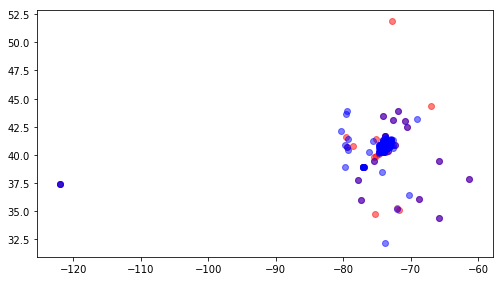

In [86]:
fig = plt.figure(figsize=(18, 10))
ax1 = fig.add_subplot(221)

plt.scatter(combined_raw['pickup_longitude'], combined_raw['pickup_latitude'], c='red', alpha=0.5)
plt.scatter(combined_raw['dropoff_longitude'], combined_raw['dropoff_latitude'], c='blue', alpha=0.5)

#sns.regplot(x='pickup_longitude',y='pickup_latitude',data=combined,scatter=True, color='red', fit_reg=False, ax=ax1)
#sns.regplot(x='dropoff_longitude',y='dropoff_latitude',data=combined,scatter=True, color='blue', fit_reg=False, ax=ax1)


There are some extreme outliers in the location data. We need to remove them to make the predictions meaningful. Lets check the boxplot of distance.

{'boxes': [<matplotlib.lines.Line2D at 0x24102476be0>],
 'caps': [<matplotlib.lines.Line2D at 0x2410248b9e8>,
 'fliers': [<matplotlib.lines.Line2D at 0x241024a8cc0>],
 'means': [],
 'medians': [<matplotlib.lines.Line2D at 0x241024a8c50>],
 'whiskers': [<matplotlib.lines.Line2D at 0x241024769e8>,
  <matplotlib.lines.Line2D at 0x241029956d8>]}

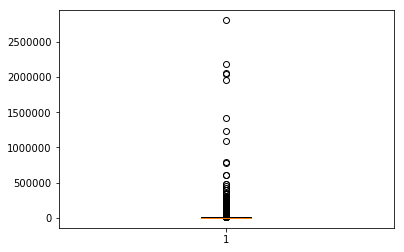

In [87]:
plt.boxplot(x=combined_raw['total_distance'], vert=True)

In [88]:
combined_raw[(combined_raw.total_distance > 300000)]

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,...,vislow,windhigh,windavg,preceiphigh,precipsum,Events,Precip,Snow,week_day,total_distance
39176,id1216866,1,2016-03-26 22:01:54,2016-03-27 00:47:16,1,-73.981491088867188,40.773250579833984,-76.135719299316406,40.243625640869134,0,...,8,14,8,25,0.000000000000000,,0.000000000000000,0.000000000000000,5,790462
325857,id0838705,1,2016-02-26 19:50:03,2016-02-26 20:08:54,1,-66.972160339355455,44.371944427490241,-69.048019409179688,43.147583007812500,0,...,10,13,5,37,0.000000000000000,,0.000000000000000,0.000000000000000,4,777920
345925,id2306955,1,2016-05-07 18:58:53,2016-05-07 19:12:05,1,-72.809669494628906,51.881084442138672,-73.987228393554688,40.750598907470703,0,...,2,14,9,17,0.010000000000000,,0.000000000000000,0.000000000000000,5,1240019
358505,id1146400,1,2016-02-15 18:57:32,2016-02-15 19:02:35,2,-73.989913940429688,40.756633758544922,-70.346076965332031,36.398120880126953,0,...,1,15,7,21,0.000000000000000,,0.440000000000000,1.400000000000000,0,1419909
392779,id1311087,1,2016-02-29 12:16:29,2016-02-29 18:47:09,3,-75.455917358398438,39.803932189941406,-73.796020507812500,40.707725524902337,0,...,8,20,10,54,0.000000000000000,,0.050000000000000,0.000000000000000,0,614125
433945,id2132644,2,2016-02-03 08:35:17,2016-02-03 10:20:33,2,-73.959846496582031,40.782382965087891,-74.775428771972656,40.364536285400391,0,...,2,13,3,24,0.000000000000000,,0.730000000000000,0.000000000000000,2,301484
477455,id1723416,1,2016-03-20 21:07:56,2016-03-20 21:12:35,1,-78.547401428222656,40.817131042480469,-79.786132812500000,40.917636871337891,0,...,3,21,13,28,0.000000000000000,,0.070000000000000,0.000000000000000,6,453823
625394,id2122095,2,2016-01-10 21:07:19,2016-01-10 22:14:51,2,-73.781799316406250,40.644653320312500,-74.613113403320298,40.584606170654297,0,...,2,24,14,38,0.000000000000000,Thunderstorm,1.800000000000000,0.000000000000000,6,304465
641492,id2663579,2,2016-03-12 22:52:33,2016-03-13 00:11:25,1,-73.789352416992188,40.643440246582031,-74.725814819335938,40.889720916748047,0,...,8,14,5,18,0.000000000000000,,0.000000000000000,0.000000000000000,5,343783
719695,id0978162,1,2016-02-24 16:20:59,2016-02-24 16:35:34,4,-75.354331970214844,34.712234497070320,-73.834922790527344,32.181140899658203,0,...,1,21,16,31,0.000000000000000,Thunderstorm,1.220000000000000,0.000000000000000,2,608356


So out of 1.4 million entries only 23 have a distance greater than 300,000 ft (90 km). We can easily omit such data. Similarly check for zero distance and negative distances covered.

In [89]:
combined_raw[(combined_raw.total_distance <= 0)]

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,...,vislow,windhigh,windavg,preceiphigh,precipsum,Events,Precip,Snow,week_day,total_distance
32,id0915475,1,2016-03-14 06:03:38,2016-03-14 06:03:43,1,-73.982406616210938,40.731143951416016,-73.982406616210938,40.731143951416016,0,...,3,24,13,37,0.000000000000000,,0.290000000000000,0.000000000000000,0,0
219,id2714516,2,2016-03-14 09:23:31,2016-03-14 09:34:10,1,-73.994277954101562,40.763389587402337,-73.994277954101562,40.763389587402337,0,...,3,24,13,37,0.000000000000000,,0.290000000000000,0.000000000000000,0,0
427,id2203067,2,2016-03-14 12:14:13,2016-03-14 12:35:35,1,-73.972450256347656,40.747928619384773,-73.972450256347656,40.747928619384773,0,...,3,24,13,37,0.000000000000000,,0.290000000000000,0.000000000000000,0,0
603,id2634150,2,2016-03-14 19:05:15,2016-03-14 19:13:53,3,-73.972229003906250,40.763912200927727,-73.972229003906250,40.763912200927727,0,...,3,24,13,37,0.000000000000000,,0.290000000000000,0.000000000000000,0,0
1456,id3140165,2,2016-03-14 12:50:37,2016-03-14 13:00:18,2,-73.920059204101562,40.651760101318359,-73.920059204101562,40.651760101318359,0,...,3,24,13,37,0.000000000000000,,0.290000000000000,0.000000000000000,0,0
1639,id0211929,2,2016-03-14 20:55:49,2016-03-14 21:04:44,1,-73.794082641601562,40.718753814697273,-73.794082641601562,40.718753814697273,0,...,3,24,13,37,0.000000000000000,,0.290000000000000,0.000000000000000,0,0
1765,id2662377,2,2016-03-14 13:13:41,2016-03-14 13:14:35,2,-73.966888427734375,40.778350830078132,-73.966888427734375,40.778350830078132,0,...,3,24,13,37,0.000000000000000,,0.290000000000000,0.000000000000000,0,0
1888,id2440662,2,2016-03-14 08:35:16,2016-03-14 08:45:21,2,-73.997200012207017,40.723930358886719,-73.997200012207017,40.723930358886719,0,...,3,24,13,37,0.000000000000000,,0.290000000000000,0.000000000000000,0,0
2207,id3807750,2,2016-03-14 14:49:40,2016-03-14 14:58:57,6,-73.992507934570298,40.730457305908203,-73.992507934570298,40.730457305908203,0,...,3,24,13,37,0.000000000000000,,0.290000000000000,0.000000000000000,0,0
2423,id2582218,2,2016-03-14 22:17:09,2016-03-14 22:23:12,1,-73.994560241699233,40.751621246337891,-73.994560241699233,40.751621246337891,0,...,3,24,13,37,0.000000000000000,,0.290000000000000,0.000000000000000,0,0


It is vindicated that there are possibly outliers. We decide a cut-off of 0.3 million feet (90 Km) and rest outliers are omitted.

In [90]:
combined = combined_raw[(combined_raw.total_distance < 300000) & (combined_raw.total_distance > 0)]
combined.shape

(1452412, 39)

It is vindicated that there are possibly outliers. We decide a cut-off of 0.3 million feet (90 Km) and rest outliers are omitted.

In [91]:
combined.shape

(1452412, 39)

{'boxes': [<matplotlib.lines.Line2D at 0x241022d0940>],
 'caps': [<matplotlib.lines.Line2D at 0x2410236b208>,
 'fliers': [<matplotlib.lines.Line2D at 0x241022de780>],
 'means': [],
 'medians': [<matplotlib.lines.Line2D at 0x241022dee10>],
 'whiskers': [<matplotlib.lines.Line2D at 0x241022d0780>,
  <matplotlib.lines.Line2D at 0x241022d0320>]}

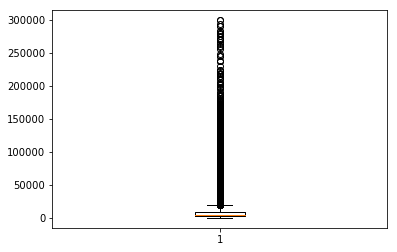

In [92]:
plt.boxplot(x=combined['total_distance'], vert=True)

### trip_duration

{'boxes': [<matplotlib.lines.Line2D at 0x241024f2128>],
 'caps': [<matplotlib.lines.Line2D at 0x2410242e0f0>,
 'fliers': [<matplotlib.lines.Line2D at 0x241023ce470>],
 'means': [],
 'medians': [<matplotlib.lines.Line2D at 0x241023cee80>],
 'whiskers': [<matplotlib.lines.Line2D at 0x241024f2e48>,
  <matplotlib.lines.Line2D at 0x2410246b400>]}

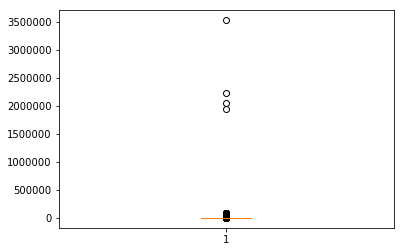

In [93]:
plt.boxplot(x=combined['trip_duration'], vert=True)

Clearly there are some suspiciously long duration trips which need to be removed to have some meaningful analysis.

In [94]:
combined = combined[(combined.trip_duration < 100000)]

{'boxes': [<matplotlib.lines.Line2D at 0x2410050e438>],
 'caps': [<matplotlib.lines.Line2D at 0x241023b2a58>,
 'fliers': [<matplotlib.lines.Line2D at 0x241025412b0>],
 'means': [],
 'medians': [<matplotlib.lines.Line2D at 0x24102541e10>],
 'whiskers': [<matplotlib.lines.Line2D at 0x2410050e048>,
  <matplotlib.lines.Line2D at 0x241024f8cc0>]}

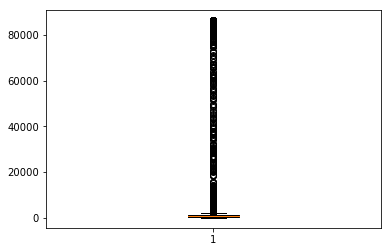

In [95]:
plt.boxplot(x=combined['trip_duration'], vert=True)

Finally, the taxi trip distance gives us a normal distribution curve.

Populating the interactive namespace from numpy and matplotlib


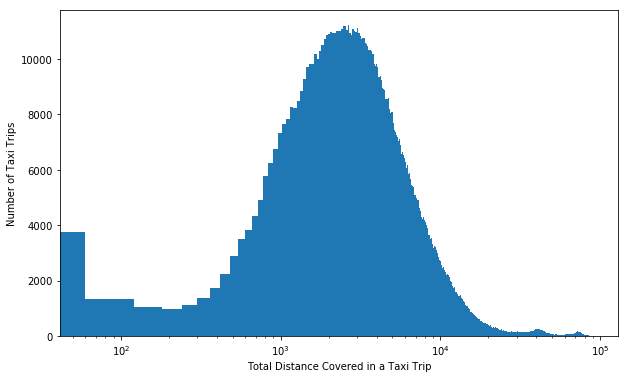

In [96]:
%pylab inline
pylab.rcParams['figure.figsize'] = (10, 6)
p = plt.hist(combined['total_distance'], bins=1500, range=(0,90000))
plt.xlabel("Total Distance Covered in a Taxi Trip")
plt.ylabel("Number of Taxi Trips")
plt.xscale('log')

### 2.2 Finding Data Correlations

### No. of taxi pickups over the various days

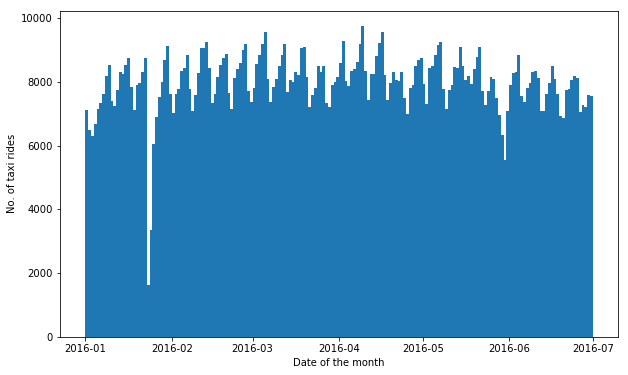

In [97]:
#combined.groupby(combined['pickup_datetime'].dt.month).count().plot(kind="bar")
#combined['pickup_datetime'].count()# .plot(kind="bar")
plt.hist(combined.pickup_datetime.values, bins=182 )
plt.xlabel("Date of the month")
plt.ylabel("No. of taxi rides")

Some days of the year have exceptionally less number of taxi rides, possibly due to bad weather conditions. Introducing external weather data will be quite useful.

### Hour of the day related to taxi trip duration

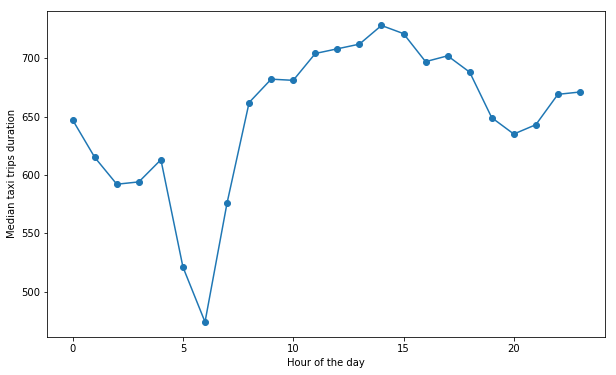

In [98]:
plt.plot(combined.trip_duration.groupby(combined.pickup_hour).median(), 'o-')
plt.xlabel("Hour of the day")
plt.ylabel("Median taxi trips duration")

This is definitely a very important feature to consider that not only affects the number of taxi trips but also the duration of those trips.

### Day of the week related to taxi trip durations

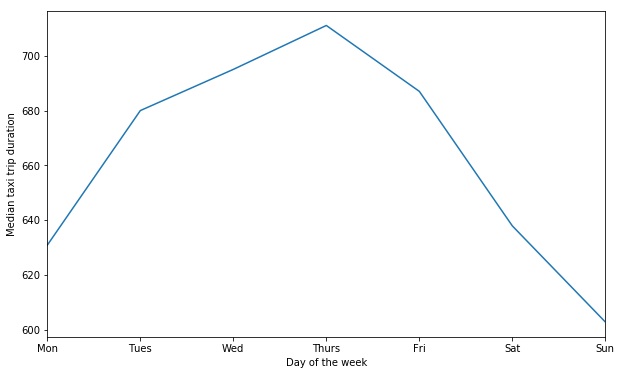

In [99]:
p=combined.trip_duration.groupby(combined.week_day).median().plot(kind='line')
p.set_xticklabels(['Mon', 'Tues', 'Wed', 'Thurs', 'Fri', 'Sat', 'Sun'])
p.set_xlabel("Day of the week")
p.set_ylabel("Median taxi trip duration")

Day of the week is definitely an important factor to consider while predicting the average taxi trip duration.

### Average daily temperature related to taxi trip duration

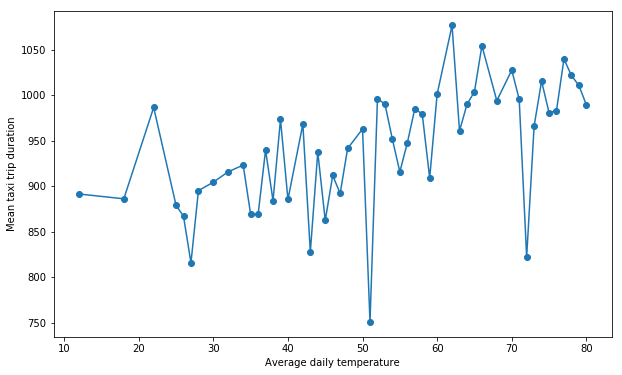

In [100]:
plt.plot(combined.trip_duration.groupby(combined.tempavg).mean(), 'o-')
plt.xlabel('Average daily temperature')
plt.ylabel('Mean taxi trip duration')

There is possibly a positive correlation between daily temperature and taxi trip durations. Some other factors are also there.

### Snow related to taxi trip duration

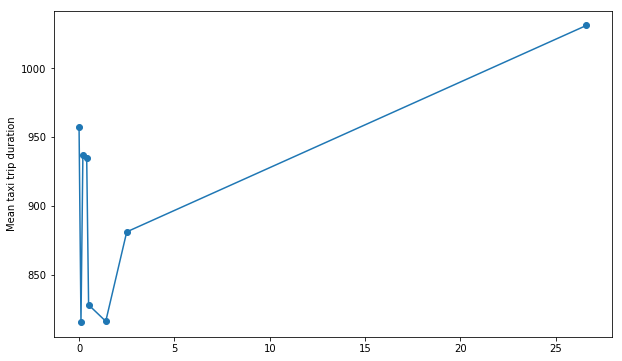

In [101]:
plt.plot(combined.trip_duration.groupby(combined.Snow).mean(), 'o-')
plt.ylabel('Mean taxi trip duration')

So, this is definitely a big factor that will affect the duration of the taxi trip keeping in mind some anomalies in the start.

### Average Humidity levels related to taxi trip duration

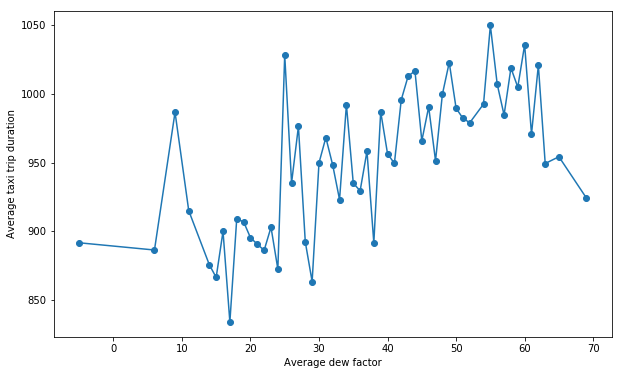

In [102]:
plt.plot(combined.trip_duration.groupby(combined.dewavg).mean(), 'o-')
plt.xlabel("Average dew factor")
plt.ylabel("Average taxi trip duration")

There is a positive correlation with some anomalies at the extreme values.

## 3. Modeling

### 3.1 Preparing the data

Finally, drop the non-numeric columns in preparation for modeling and algorithm training.

In [103]:
combined = combined.reset_index()

In [104]:
target1 = combined['trip_duration']
combined1 = combined.drop(['id','index','Date','Events','trip_duration','pickup_datetime','dropoff_datetime','pickup_date'], axis=1)
combined1

,vendor_id,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,pickup_hour,pickup_minute,temphigh,...,visavg,vislow,windhigh,windavg,preceiphigh,precipsum,Precip,Snow,week_day,total_distance
0,2,1,-73.982154846191392,40.767936706542969,-73.964630126953125,40.765602111816406,0,17,24,51,...,8,3,24,13,37,0.000000000000000,0.290000000000000,0.000000000000000,0,6421
1,1,1,-73.975090026855469,40.758766174316406,-73.953201293945312,40.765068054199219,0,14,5,51,...,8,3,24,13,37,0.000000000000000,0.290000000000000,0.000000000000000,0,8040
2,1,1,-73.994483947753906,40.745086669921882,-73.998992919921875,40.722709655761719,0,15,4,51,...,8,3,24,13,37,0.000000000000000,0.290000000000000,0.000000000000000,0,2798
3,2,3,-73.944358825683580,40.714488983154297,-73.910530090332031,40.709491729736328,0,4,24,51,...,8,3,24,13,37,0.000000000000000,0.290000000000000,0.000000000000000,0,12397
4,2,1,-73.952880859375000,40.766468048095696,-73.978630065917969,40.761920928955078,0,14,57,51,...,8,3,24,13,37,0.000000000000000,0.290000000000000,0.000000000000000,0,9439
5,2,1,-73.981910705566406,40.766880035400391,-73.982597351074219,40.777179718017578,0,20,31,51,...,8,3,24,13,37,0.000000000000000,0.290000000000000,0.000000000000000,0,1071
6,1,1,-73.953887939453125,40.766952514648438,-73.953849792480483,40.787883758544922,0,7,55,51,...,8,3,24,13,37,0.000000000000000,0.290000000000000,0.000000000000000,0,2119
7,1,1,-73.954124450683580,40.763881683349609,-73.972961425781250,40.764476776123047,0,20,11,51,...,8,3,24,13,37,0.000000000000000,0.290000000000000,0.000000000000000,0,6897
8,2,1,-73.862754821777344,40.768833160400391,-73.988403320312500,40.734615325927727,0,10,52,51,...,8,3,24,13,37,0.000000000000000,0.290000000000000,0.000000000000000,0,46138
9,2,2,-73.959411621093750,40.779960632324219,-73.980690002441406,40.782768249511719,0,15,32,51,...,8,3,24,13,37,0.000000000000000,0.290000000000000,0.000000000000000,0,7796


In [41]:
combined1.to_excel("taxi_res.xlsx")

### 3.2 Model training

In [145]:
clf = ExtraTreesRegressor(n_estimators=50, criterion='mse', max_features='sqrt')
clf = clf.fit(combined1, target1)

In [146]:
features = pd.DataFrame()
features['feature'] = combined.columns

In [44]:
features['importance'] = clf.feature_importances_

ValueError: Length of values does not match length of index

In [147]:
clf.score(combined1, target1)

0.99999998736414719

### 3.3 Prepare test data and predict

In [148]:
weather = pd.read_csv(weather_file, header = 0)
test = pd.read_csv(test_file, header = 0)

In [149]:
weather['Date'] = pd.DatetimeIndex(pd.to_datetime(weather['Date'])).date
test['pickup_date'] = pd.DatetimeIndex(pd.to_datetime(test['pickup_datetime'])).date
test['pickup_hour'] = pd.DatetimeIndex(pd.to_datetime(test['pickup_datetime'])).hour
test['pickup_minute'] = pd.DatetimeIndex(pd.to_datetime(test['pickup_datetime'])).minute

In [150]:
test_raw = pd.merge(test, weather, how='inner', left_on='pickup_date', right_on='Date')
test_raw['week_day'] = pd.DatetimeIndex(test_raw.pickup_datetime).weekday

In [151]:
test_raw['store_and_fwd_flag'] = test_raw['store_and_fwd_flag'].map({'Y':1 , 'N':0, 1:1, 0:0})
test_raw['total_distance'] = test_raw.apply(lambda x: vincenty((x['pickup_longitude'],x['pickup_latitude']), (x['dropoff_longitude'], x['dropoff_latitude'])).feet, axis=1).astype(int)
test_raw['pickup_datetime'] = pd.to_datetime(test_raw['pickup_datetime'])

In [152]:
test1 = test_raw.drop(['id','Date','Events','pickup_datetime','pickup_date'], axis=1)

In [153]:
test1.shape

(625134, 32)

In [ ]:
res = clf.predict(test1)

In [ ]:
Xtr, Xv, ytr, yv = train_test_split(train[feature_names].values, y, test_size=0.2, random_state=1987)
dtrain = xgb.DMatrix(Xtr, label=ytr)
dvalid = xgb.DMatrix(Xv, label=yv)
dtest = xgb.DMatrix(test[feature_names].values)
watchlist = [(dtrain, 'train'), (dvalid, 'valid')]

# Try different parameters! My favorite is random search :)
xgb_pars = {'min_child_weight': 50, 'eta': 0.3, 'colsample_bytree': 0.3, 'max_depth': 10,
            'subsample': 0.8, 'lambda': 1., 'nthread': -1, 'booster' : 'gbtree', 'silent': 1,
            'eval_metric': 'rmse', 'objective': 'reg:linear'}

In [828]:
combined.dtypes

vendor_id                      int64
pickup_datetime       datetime64[ns]
dropoff_datetime      datetime64[ns]
passenger_count                int64
pickup_longitude             float64
pickup_latitude              float64
dropoff_longitude            float64
dropoff_latitude             float64
store_and_fwd_flag             int64
trip_duration                  int64
pickup_date                   object
pickup_hour                    int64
pickup_minute                  int64
temphigh                       int64
tempavg                        int64
templow                        int64
dewhigh                        int64
dewavg                         int64
dewlow                         int64
humhigh                        int64
humavg                         int64
humlow                         int64
seahigh                      float64
seaavg                       float64
sealow                       float64
vishigh                        int64
visavg                         int64
v

### Make a separate column for Month and Date

In [18]:
df['Date']=df['pickup_datetime'].dt.year.map(str)+'-'+df['pickup_datetime'].dt.month.map(str)+'-'+df['pickup_datetime'].dt.day.map(str)
df['Date']=pd.to_datetime(df['Date'])
df_w['Date']=pd.to_datetime(df_w['Date'])

df_w.head()
#print("The deed is done")

,Date,temphigh,tempavg,templow,dewhigh,dewavg,dewlow,humhigh,humavg,humlow,...,vishigh,visavg,vislow,windhigh,windavg,preceiphigh,precipsum,Events,Precip,Snow
0,2016-01-01,44,40,37,32,28,21,70,61,52,...,10,10,8,23,8,39,0.000000000000000,,0.000000000000000,0.000000000000000
1,2016-01-02,42,38,35,27,24,21,70,57,49,...,10,10,9,16,10,34,0.000000000000000,,0.000000000000000,0.000000000000000
2,2016-01-03,48,42,35,28,27,25,70,60,40,...,10,10,8,17,10,33,0.000000000000000,,0.000000000000000,0.000000000000000
3,2016-01-04,37,28,19,28,17,7,74,57,32,...,10,10,8,13,5,28,0.000000000000000,,0.000000000000000,0.000000000000000
4,2016-01-05,35,25,15,18,11,5,93,55,33,...,10,10,9,14,6,40,0.000000000000000,,0.000000000000000,0.000000000000000


### Let's join weather data:

In [19]:
df_join=df[df['within_min_range']<130].merge(df_w, on='Date', how='inner')

print("The deed is done")
df_join.head()

The deed is done


,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,...,vishigh,visavg,vislow,windhigh,windavg,preceiphigh,precipsum,Events,Precip,Snow
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982154846191392,40.767936706542969,-73.964630126953125,40.765602111816406,0,...,10,8,3,24,13,37,0.000000000000000,,0.290000000000000,0.000000000000000
1,id2129090,1,2016-03-14 14:05:39,2016-03-14 14:28:05,1,-73.975090026855469,40.758766174316406,-73.953201293945312,40.765068054199219,0,...,10,8,3,24,13,37,0.000000000000000,,0.290000000000000,0.000000000000000
2,id0256505,1,2016-03-14 15:04:38,2016-03-14 15:16:13,1,-73.994483947753906,40.745086669921882,-73.998992919921875,40.722709655761719,0,...,10,8,3,24,13,37,0.000000000000000,,0.290000000000000,0.000000000000000
3,id3863815,2,2016-03-14 04:24:36,2016-03-14 04:37:11,3,-73.944358825683580,40.714488983154297,-73.910530090332031,40.709491729736328,0,...,10,8,3,24,13,37,0.000000000000000,,0.290000000000000,0.000000000000000
4,id3817493,2,2016-03-14 14:57:56,2016-03-14 15:15:26,1,-73.952880859375000,40.766468048095696,-73.978630065917969,40.761920928955078,0,...,10,8,3,24,13,37,0.000000000000000,,0.290000000000000,0.000000000000000


## Data Analysis

### Check which columns are numeric in data

### Data types:

In [20]:
df.dtypes

id                            object
vendor_id                      int64
pickup_datetime       datetime64[ns]
dropoff_datetime      datetime64[ns]
passenger_count                int64
pickup_longitude             float64
pickup_latitude              float64
dropoff_longitude            float64
dropoff_latitude             float64
store_and_fwd_flag             int64
trip_duration                  int64
within_min_range               int64
total_distance                 int32
Date                  datetime64[ns]
dtype: object

In [21]:
df_join.dtypes

id                            object
vendor_id                      int64
pickup_datetime       datetime64[ns]
dropoff_datetime      datetime64[ns]
passenger_count                int64
pickup_longitude             float64
pickup_latitude              float64
dropoff_longitude            float64
dropoff_latitude             float64
store_and_fwd_flag             int64
trip_duration                  int64
within_min_range               int64
total_distance                 int32
Date                  datetime64[ns]
temphigh                       int64
tempavg                        int64
templow                        int64
dewhigh                        int64
dewavg                         int64
dewlow                         int64
humhigh                        int64
humavg                         int64
humlow                         int64
seahigh                      float64
seaavg                       float64
sealow                       float64
vishigh                        int64
v

### Finding missing values:

In [22]:
df.count() 

id                    1458644
vendor_id             1458644
pickup_datetime       1458644
dropoff_datetime      1458644
passenger_count       1458644
pickup_longitude      1458644
pickup_latitude       1458644
dropoff_longitude     1458644
dropoff_latitude      1458644
store_and_fwd_flag    1458644
trip_duration         1458644
within_min_range      1458644
total_distance        1458644
Date                  1458644
dtype: int64

So we have do not have any missing data in this data set.

### Data range for data

In [23]:
print("pickup_datetime min is " + str(df['pickup_datetime'].min()) + " and max is " + str(df['pickup_datetime'].max()))
print("dropoff_datetime min is " + str(df['dropoff_datetime'].min()) + " and max is " + str(df['dropoff_datetime'].max()))
print("trip_duration min is " + str(df['trip_duration'].min()) + " and max is " + str(df['trip_duration'].max()))
#print df.loc[[978383]]


pickup_datetime min is 2016-01-01 00:00:17 and max is 2016-06-30 23:59:39
dropoff_datetime min is 2016-01-01 00:03:31 and max is 2016-07-01 23:02:03
trip_duration min is 1 and max is 3526282


### Let's see if we have uniqueness in data

In [24]:
df.apply(pd.Series.nunique)



id                    1458644
vendor_id                   2
pickup_datetime       1380222
dropoff_datetime      1380377
passenger_count            10
pickup_longitude        23047
pickup_latitude         45245
dropoff_longitude       33821
dropoff_latitude        62519
store_and_fwd_flag          2
trip_duration            7417
within_min_range           25
total_distance          72615
Date                      182
dtype: int64

### Strip Off Non Numeric Columns

In [25]:
numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
nonnumeric_cols=df_join.select_dtypes(exclude=numerics).columns.values
print("Non numeric columns to look out for: " + str(nonnumeric_cols))

Non numeric columns to look out for: ['id' 'pickup_datetime' 'dropoff_datetime' 'Date' 'Events']


### Do we need these? Let's say no for now

In [20]:
#df_join = df_join.drop(['id','pickup_datetime','dropoff_datetime','Events'],axis=1)
print("Non-numeric columns dropped")


Non-numeric columns dropped


In [31]:
df_join.dtypes
#df_join["id"]

id                            object
vendor_id                      int64
pickup_datetime       datetime64[ns]
dropoff_datetime      datetime64[ns]
passenger_count                int64
pickup_longitude             float64
pickup_latitude              float64
dropoff_longitude            float64
dropoff_latitude             float64
store_and_fwd_flag             int64
trip_duration                  int64
within_min_range               int64
total_distance                 int32
Date                  datetime64[ns]
temphigh                       int64
tempavg                        int64
templow                        int64
dewhigh                        int64
dewavg                         int64
dewlow                         int64
humhigh                        int64
humavg                         int64
humlow                         int64
seahigh                      float64
seaavg                       float64
sealow                       float64
vishigh                        int64
v

### Fixing missing values..

Let's see if we have any missing values anywhere

In [32]:
df_join.isnull().values.any()

False

### Free up Memory

In [23]:
#Release memory
del df
#del df_join

# Visualization:

Let us see now if there is any relationship between average monthly temperature versus trip duration and total_distance

In [33]:
#Aggregation and Joins:
df_bar = df_join.groupby('tempavg', as_index=False)['trip_duration','total_distance'].mean()

df_bar_count21 = df_join.groupby(['tempavg','Date'], as_index=False)['id'].count()
df_bar_count = df_bar_count21.groupby(['tempavg'], as_index=False)['id'].sum()
df_bar_join=df_bar.merge(df_bar_count, on='tempavg', how='inner')


Correlation between average daily temperature and total trip duration covered is: 0.645687235493
Correlation between average daily temperature and total distance covered is: 0.488147161639
Correlation between average daily temperature and total rides is: 0.0702330533882


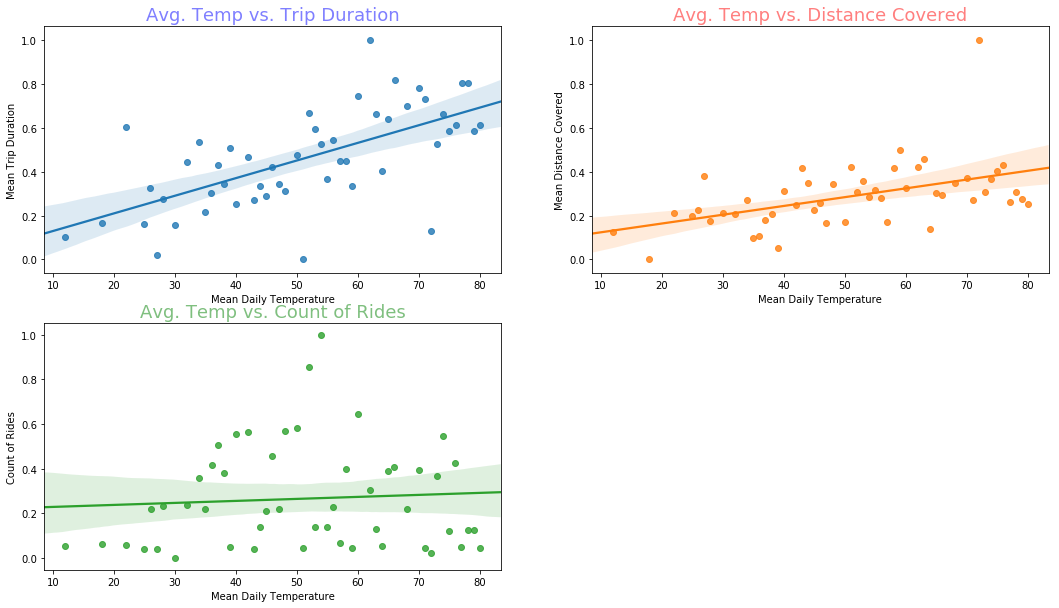

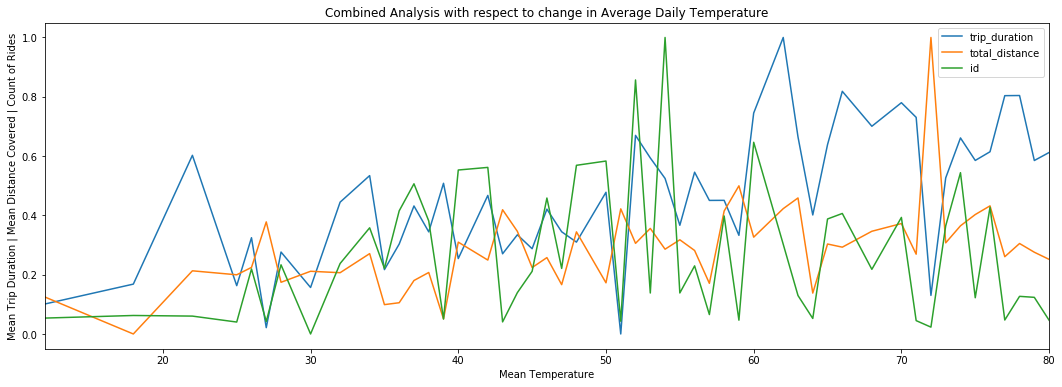

In [34]:
#Scaling:
features_to_scale = ['trip_duration','total_distance','id']
df_bar_join[features_to_scale] -= df_bar_join[features_to_scale].min()  # equivalent to df = df - df.min()
df_bar_join[features_to_scale] /= df_bar_join[features_to_scale].max() 

#Plotting:
fig = plt.figure(figsize=(18, 10))
ax1 = fig.add_subplot(221)
ax2 = fig.add_subplot(222)
ax3 = fig.add_subplot(223)

sns.regplot(x='tempavg',y='trip_duration',data=df_bar_join,fit_reg=True, ax=ax1)
sns.regplot(x='tempavg',y='total_distance',data=df_bar_join,fit_reg=True, ax=ax2)
sns.regplot(x='tempavg',y='id',data=df_bar_join,fit_reg=True, ax=ax3)

ax1.set(xlabel='Mean Daily Temperature', ylabel='Mean Trip Duration')
ax2.set(xlabel='Mean Daily Temperature', ylabel='Mean Distance Covered')
ax3.set(xlabel='Mean Daily Temperature', ylabel='Count of Rides')
ax1.set_title('Avg. Temp vs. Trip Duration', fontsize=18,color="b",alpha=0.5)
ax2.set_title('Avg. Temp vs. Distance Covered', fontsize=18,color="r",alpha=0.5)
ax3.set_title('Avg. Temp vs. Count of Rides', fontsize=18,color="g",alpha=0.5)

#Combined Graph:
ax = df_bar_join.plot(x='tempavg',figsize=(18, 6),title = 'Combined Analysis with respect to change in Average Daily Temperature')
ax.set_ylabel('Mean Trip Duration | Mean Distance Covered | Count of Rides')
ax.set_xlabel('Mean Temperature')

#Coorelation Analysis:
print('Correlation between average daily temperature and total trip duration covered is: '+ str(pd.to_numeric(df_bar_join['tempavg']).corr(df_bar_join['trip_duration'])))
print('Correlation between average daily temperature and total distance covered is: '+ str(pd.to_numeric(df_bar_join['tempavg']).corr(df_bar_join['total_distance'])))
print('Correlation between average daily temperature and total rides is: '+ str(pd.to_numeric(df_bar_join['tempavg']).corr(df_bar_join['id'])))


We can make three assumptions here:

When the average daily goes up, there is gradual increase in :

1- Total distance covered is slightly correlated to increase in temperature
2- Total trip Duration is relatively more correlated to increase in temperature
3- Temperature increase does not have any significant impact on total number of rides

Keeping in view point number 3, we can attribute total increase in duration and distance to increase in traffic. Causes for this increase are ambiguous at this point. Something to work on for future

Now, lets do some **Vendor Analysis**

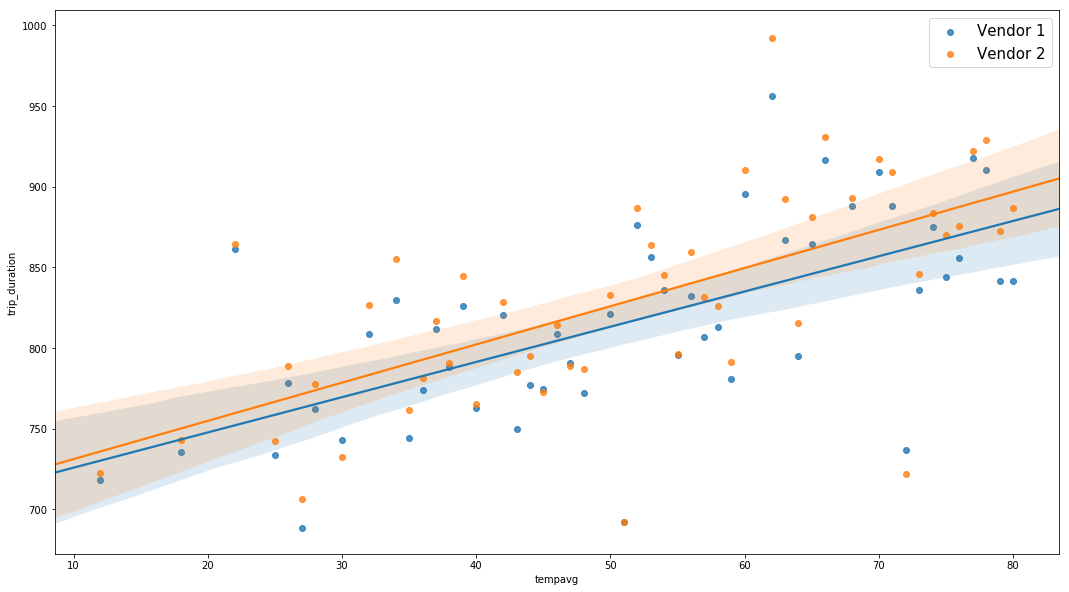

In [35]:
df_bar = df_join.groupby(['tempavg','vendor_id'], as_index=False)['trip_duration'].mean()

fig = plt.figure(figsize=(18, 10))
ax1 = fig.add_subplot(111)

sns.regplot(x='tempavg',y='trip_duration',data=df_bar[df_bar['vendor_id']==1],fit_reg=True, ax=ax1, label = 'Vendor 1')
sns.regplot(x='tempavg',y='trip_duration',data=df_bar[df_bar['vendor_id']==2],fit_reg=True, ax=ax1, label = 'Vendor 2')
ax1.legend(loc=1, prop={'size': 15})


Not much behavior difference between the two vendors with respect to temperature

# Train/Test split

In [36]:
np.random.seed()
msk = np.random.rand(len(df_join)) < 0.8
dfTrain = df_join[msk]
dfTest = df_join[~msk]

print(len(dfTrain))
print(len(dfTest))

1165014
291377


# Multi Variate Regression Analysis

Let's build and MVR

In [37]:
df_Train_features = pd.DataFrame(dfTrain.copy())
df_Train_features = df_Train_features.drop(['trip_duration','Date','within_min_range'],axis=1)
features = list(df_Train_features.columns[1:])
del df_Train_features
features

 

['vendor_id',
 'pickup_datetime',
 'dropoff_datetime',
 'passenger_count',
 'pickup_longitude',
 'pickup_latitude',
 'dropoff_longitude',
 'dropoff_latitude',
 'store_and_fwd_flag',
 'total_distance',
 'temphigh',
 'tempavg',
 'templow',
 'dewhigh',
 'dewavg',
 'dewlow',
 'humhigh',
 'humavg',
 'humlow',
 'seahigh',
 'seaavg',
 'sealow',
 'vishigh',
 'visavg',
 'vislow',
 'windhigh',
 'windavg',
 'preceiphigh',
 'precipsum',
 'Events',
 'Precip',
 'Snow']

Prepare for clustering the pickup coordinates:

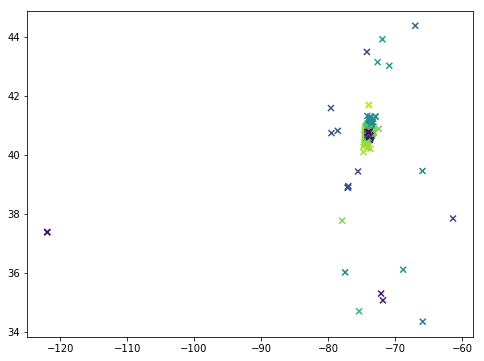

In [38]:
model = KMeans(n_clusters=50)
model = model.fit(scale(dfTrain[['pickup_longitude', 'pickup_latitude']]))
plt.figure(figsize=(8, 6))
plt.scatter(dfTrain['pickup_longitude'], dfTrain['pickup_latitude'], c=model.labels_.astype(float),marker='x')

Prepare for clustering the dropoff coordinates:

In [39]:
dfTrain.dtypes

id                            object
vendor_id                      int64
pickup_datetime       datetime64[ns]
dropoff_datetime      datetime64[ns]
passenger_count                int64
pickup_longitude             float64
pickup_latitude              float64
dropoff_longitude            float64
dropoff_latitude             float64
store_and_fwd_flag             int64
trip_duration                  int64
within_min_range               int64
total_distance                 int32
Date                  datetime64[ns]
temphigh                       int64
tempavg                        int64
templow                        int64
dewhigh                        int64
dewavg                         int64
dewlow                         int64
humhigh                        int64
humavg                         int64
humlow                         int64
seahigh                      float64
seaavg                       float64
sealow                       float64
vishigh                        int64
v

MVR starts here

In [40]:
features=['vendor_id','passenger_count','store_and_fwd_flag','total_distance','temphigh','tempavg','templow','dewhigh','dewavg','dewlow','humhigh','humavg','humlow','vishigh','visavg','vislow','windhigh','windavg','preceiphigh']
X = scale(dfTrain[features])
y = dfTrain['trip_duration']

clf = ExtraTreesRegressor()
est = clf.fit(X,y)

clf.score(scale(dfTest[features]),dfTest['trip_duration'])

#est.summary()

0.33505831101003536

# Test- Mania

In [44]:
test_file = "test.csv"
df_Test = pd.read_csv(test_file, header = 0)

df_Test['pickup_datetime'] = pd.to_datetime(df_Test['pickup_datetime'])
#df_Test['dropoff_datetime'] = pd.to_datetime(df_Test['dropoff_datetime'])
df_w['Date'] = pd.to_datetime(df_w['Date'])

d={'Y':1 , 'N':0}
df_Test['store_and_fwd_flag'] = df_Test['store_and_fwd_flag'].map(d)
df_Test['total_distance'] = df_Test.apply(lambda x: vincenty((x['pickup_longitude'],x['pickup_latitude']), (x['dropoff_longitude'],   x['dropoff_latitude'])).feet, axis=1).astype(int)

df_Test['Date']=df_Test['pickup_datetime'].dt.year.map(str)+'-'+df_Test['pickup_datetime'].dt.month.map(str)+'-'+df_Test['pickup_datetime'].dt.day.map(str)
df_Test['Date']=pd.to_datetime(df_Test['Date'])
df_w['Date']=pd.to_datetime(df_w['Date'])


In [52]:

df_Test.dtypes
#df_Test.head()

id                            object
vendor_id                      int64
pickup_datetime       datetime64[ns]
passenger_count                int64
pickup_longitude             float64
pickup_latitude              float64
dropoff_longitude            float64
dropoff_latitude             float64
store_and_fwd_flag             int64
total_distance                 int32
Date                  datetime64[ns]
dtype: object

In [53]:
df_w.head()

,Date,temphigh,tempavg,templow,dewhigh,dewavg,dewlow,humhigh,humavg,humlow,...,vishigh,visavg,vislow,windhigh,windavg,preceiphigh,precipsum,Events,Precip,Snow
0,2016-01-01,44,40,37,32,28,21,70,61,52,...,10,10,8,23,8,39,0.000000000000000,,0.000000000000000,0.000000000000000
1,2016-01-02,42,38,35,27,24,21,70,57,49,...,10,10,9,16,10,34,0.000000000000000,,0.000000000000000,0.000000000000000
2,2016-01-03,48,42,35,28,27,25,70,60,40,...,10,10,8,17,10,33,0.000000000000000,,0.000000000000000,0.000000000000000
3,2016-01-04,37,28,19,28,17,7,74,57,32,...,10,10,8,13,5,28,0.000000000000000,,0.000000000000000,0.000000000000000
4,2016-01-05,35,25,15,18,11,5,93,55,33,...,10,10,9,14,6,40,0.000000000000000,,0.000000000000000,0.000000000000000


In [55]:

df_join_Test=df_Test.merge(df_w, on='Date', how='inner')


df_join_Test.head()


,id,vendor_id,pickup_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,total_distance,...,vishigh,visavg,vislow,windhigh,windavg,preceiphigh,precipsum,Events,Precip,Snow
0,id3004672,1,2016-06-30 23:59:58,1,-73.988128662109375,40.732028961181641,-73.990173339843750,40.756679534912102,0,2600,...,10,10,9,10,4,44,0.000000000000000,,0.000000000000000,0.000000000000000
1,id3505355,1,2016-06-30 23:59:53,1,-73.964202880859375,40.679992675781250,-73.959808349609375,40.655403137207031,0,2963,...,10,10,9,10,4,44,0.000000000000000,,0.000000000000000,0.000000000000000
2,id1217141,1,2016-06-30 23:59:47,1,-73.997436523437500,40.737583160400391,-73.986160278320298,40.729522705078132,0,4208,...,10,10,9,10,4,44,0.000000000000000,,0.000000000000000,0.000000000000000
3,id2150126,2,2016-06-30 23:59:41,1,-73.956069946289062,40.771900177001953,-73.986427307128906,40.730468750000000,0,11879,...,10,10,9,10,4,44,0.000000000000000,,0.000000000000000,0.000000000000000
4,id1598245,1,2016-06-30 23:59:33,1,-73.970214843750000,40.761474609375000,-73.961509704589844,40.755889892578132,0,3237,...,10,10,9,10,4,44,0.000000000000000,,0.000000000000000,0.000000000000000


In [ ]:

df_join_Test = df_join_Test.drop(['id','pickup_datetime','Events'],axis=1)
print("The deed is done")

clf.score(scale(df_join_Test[features]),df_join_Test['trip_duration'])

## Using Random forests

We'll use a random forest of 10 decision trees to predict employment of specific candidate profiles:

In [265]:
from sklearn.feature_selection import RFE

clf = RandomForestClassifier(n_estimators=100) #means make 1000 random forests
clf = clf.fit(X, y)

#dfTest.head()

#dtTrainResults_RF=DataFrame(clf.predict(dfTrain[features]),columns=list([['Survived']]))
dtTestResults_RF=DataFrame(clf.predict(dfTest[features]),columns=list([['Survived']]))

#accuracy_score(dfTrain['Survived'], dtTrainResults_RF['Survived'], sample_weight=None)
accuracy_score(dfTest['Survived'], dtTestResults_RF['Survived'], sample_weight=None)

#RFE#
#rfe = RFE(clf, 3)
#rfe.fit(X, y)
#dtTestResults_RF=DataFrame(clf.predict(dfTest[features]),columns=list([['Survived']]))
#print accuracy_score(dfTest['Survived'], dtTestResults_RF['Survived'], sample_weight=None)

0.81714285714285717

# Results/Testing

Now let's perform prediction on original Test dataset

In [266]:
#Now performing this on real test set
##################
# 1 #Loading file
##################
test_file = "E:/2- GoogleDrive (Total 15GB)/Interests/Machine Learning/Udemy - Data Science and Machine Learning with Python/DataScience/TitanicTest.csv"
dfTestFinal = pd.read_csv(test_file,header=0)

##################
# 2 #Rectifying missing values
##################
d = {'male': 1, 'female': 0}
dfTestFinal['Sex'] = dfTestFinal['Sex'].map(d)
d = {'S': 0, 'Q': 1 ,'C':2}
dfTestFinal['Embarked']=dfTestFinal['Embarked'].map(d)
missFix_Test=dfTestFinal[features]
fill_NaN_Test = Imputer(missing_values=np.nan, strategy='median', axis=1)
imputed_DF_Test = pd.DataFrame(fill_NaN_Test.fit_transform(missFix_Test))
imputed_DF_Test.columns = missFix_Test.columns
imputed_DF_Test.index = missFix_Test.index

##################
# 3 #Performing Prediction
##################
clf.predict(imputed_DF_Test[features])
dtTestResults_RF_Final=DataFrame(clf.predict(imputed_DF_Test[features]),columns=list([['Survived']]))

#RFE#
#rfe.predict(imputed_DF_Test[features])
#dtTestResults_RF_Final=DataFrame(rfe.predict(imputed_DF_Test[features]),columns=list([['Survived']]))

##################
# 4 #Exporting Results
##################
Results_Main = dfTestFinal.join(dtTestResults_RF_Final['Survived'])
results_file = "E:/2- GoogleDrive (Total 15GB)/Interests/Machine Learning/Udemy - Data Science and Machine Learning with Python/DataScience/TitanicResults.csv"
Results_Main.to_csv(results_file)


## Tree Graphical Representation

Display it. Note you need to have pyplot2 installed for this to work.

To read this decision tree, each condition branches left for "true" and right for "false". When you end up at a value, the value array represents how many samples exist in each target value. So value = [0. 5.] mean there are 0 "Not Survived" and 5 "Survived" by the time we get to that point. value = [3. 0.] means 3 Not Survived and 0 Survived.

In [417]:
#Added to fix "GraphViz's executables not found" issue
import os
os.environ["PATH"] += os.pathsep + 'C:/Program Files (x86)/Graphviz2.38/bin/'

In [245]:
from IPython.display import Image  
from sklearn.externals.six import StringIO  
import pydot 

dot_data = StringIO()  #To save tree in it in next step

tree.export_graphviz(
                    clf, #the fitted tree itself
                    out_file=dot_data,  #Save the output tree in this variable in dotted format
                    feature_names=features #Input features to the tree for them to be displayed in tree
                    )  
graph = pydot.graph_from_dot_data(dot_data.getvalue())  #convert dotted format to visual graph
Image(graph.create_png())  #Convert 'graph' image above to png

NameError: name 'clf' is not defined

# ROUGH WORK!

**Following was just testing to use OLS for finding missing values**

In [ ]:
def min_bucket_func(row):    
    if row >= 0 and row < 300*24 :
        return math.floor((row/60)/5)
    else:
        return 200

train['within_min_range']=train['trip_duration'].apply(lambda x: min_bucket_func(x))

In [289]:
#Age_NMiss = df[df.Age.notnull()] #This is data where we have Age
#Age_Miss = df[df.Age.isnull()] #This is data where we DO NOT have Age

#Age_NMiss_Train = Age_NMiss[80:]
#Age_NMiss_Test = Age_NMiss[:80]

import statsmodels.api as sm
from sklearn.preprocessing import StandardScaler
import itertools

scale = StandardScaler()

#Columns list to consider for X
potentialFeatures=np.array(['Survived','Pclass','SibSp','Parch','Sex']).tolist()

#Making Y
#y=Age_NMiss_Train['Age']
y=scale.fit_transform(Age_NMiss_Train['Age'].as_matrix())


#Setting temporary values
max_X = 0.0

for iteration in range(1,len(potentialFeatures)+1):
    for stuff in itertools.combinations(potentialFeatures, iteration):
        Age_features=np.array(stuff).tolist()
        #Making X
        X = Age_NMiss_Train[Age_features]
        X[Age_features] = scale.fit_transform(X[Age_features].as_matrix())
        #Making OLS Model
        est = sm.OLS(y, X).fit()
        #Get max
        if max_X < est.rsquared:
            max_X=est.rsquared
            best_Features=stuff
            print str(max_X) + " " + str(Age_features)

print "and the final is"
bestFeatureFinal=np.array(best_Features).tolist()
X = Age_NMiss_Train[bestFeatureFinal]
X[bestFeatureFinal] = scale.fit_transform(X[bestFeatureFinal].as_matrix())
est2 = sm.OLS(y, X).fit()
print str(est2.rsquared) + str(bestFeatureFinal)

#print est2.predict(scale.fit_transform(Age_NMiss_Test[bestFeatureFinal].as_matrix()),Age_NMiss_Test['Age'])
#y=scale.inverse_transform(est2.predict(Age_NMiss_Test[bestFeatureFinal]))
#print y


C:\Users\MK255019\AppData\Local\Enthought\Canopy\User\lib\site-packages\sklearn\preprocessing\data.py:586: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)
C:\Users\MK255019\AppData\Local\Enthought\Canopy\User\lib\site-packages\sklearn\preprocessing\data.py:649: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)
C:\Users\MK255019\AppData\Local\Enthought\Canopy\User\lib\site-packages\ipykernel\__main__.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using 

0.0066135016075 ['Survived']
0.127541486462 ['Pclass']
0.183104766203 ['Survived', 'Pclass']
0.202298667301 ['Pclass', 'SibSp']
0.25493576747 ['Survived', 'Pclass', 'SibSp']
0.257893052876 ['Survived', 'Pclass', 'SibSp', 'Parch']
0.25789313005 ['Survived', 'Pclass', 'SibSp', 'Parch', 'Sex']
and the final is
0.25789313005['Survived', 'Pclass', 'SibSp', 'Parch', 'Sex']


C:\Users\MK255019\AppData\Local\Enthought\Canopy\User\lib\site-packages\ipykernel\__main__.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
